## Jack's Car Rental

In [74]:
import matplotlib.pyplot as plt
%pylab inline
from scipy.stats import poisson
import time
from IPython.core.pylabtools import figsize
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
def cmpt_P_and_R(lambdaRequests,lambdaReturns,max_n_cars,max_num_cars_can_transfer):
    # the number of possible cars at any site first thing in the morning: 
    nCM = np.arange(0, max_n_cars+max_num_cars_can_transfer+1)
    # return the average rewards: 
    R = np.zeros(len(nCM))
    for n in nCM:
        tmp = 0.0 
        for nr in np.arange(0, (10*lambdaRequests+1)): # <- a value where the probability of request is very small. 
            tmp = tmp + 10*min(n,nr)*poisson.pmf(nr, lambdaRequests)
        R[n] = tmp 


    # return the probabilities: 
    P = np.zeros((len(nCM),max_n_cars+1)) 
    for nreq in np.arange(0, 10*lambdaRequests+1):  #<- a value where the probability of request is very small. 
        reqP = poisson.pmf(nreq, lambdaRequests); 
        
        #for all possible returns:
        for nret in np.arange(0, 10*lambdaReturns+1): # <- a value where the probability of returns is very small. 
            retP = poisson.pmf(nret, lambdaReturns)

            #for all possible morning states: 
            for n in nCM:
              sat_requests = min(n,nreq); #satisfied requests 
              new_n = max(0, min(max_n_cars, n+nret-sat_requests) )
              P[n, new_n] = P[n, new_n] + reqP*retP
    return R, P

 JCR_POLICY_EVALUATION - Performs policy evaluation evaluations returning the state-value function for the jacks car rental example.
 
  The Basic Algorithm is: Iterate the Bellman equation: 
 
  $$ V(s) = \sum_a \pi(s,a) \sum_{s'} P_{s,s'}^a (R_{s,s'}^a + \gamma V(s'))$$
 
  where the policy is given as input.  These iterations are done IN PLACE.
 
  See ePage 262 in the Sutton book.
 
  Input: 
    V = An array to hold the values of the state-value function 

In [5]:
def jcr_policy_evaluation(V,pol_pi,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer):
    max_n_cars = V.shape[0]-1
    nStates = (max_n_cars+1)**2
    MAX_N_ITERS = 100
    iterCnt = 0 
    CONV_TOL = 1e-6
    delta = np.inf
    
    print ('beginning policy evaluation ... \n'); 
    while( (delta > CONV_TOL) and (iterCnt <= MAX_N_ITERS) ) :
        delta = 0; 
        for si in range(0, nStates): 
            # get the number of cars (ones based) at each site (at the END of the day): 
            
            [na,nb] = np.unravel_index(si, [max_n_cars+1, max_n_cars+1]); 
            v = V[na, nb]  
            ntrans = pol_pi[na,nb]
            V[na,nb] = jcr_rhs_state_value_bellman(na,nb,ntrans,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer)
            delta = max([delta, abs( v - V[na,nb])]) 
        iterCnt=iterCnt+1;
    return V



In [6]:
def jcr_policy_improvement(pol_pi,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer):
  
    # the maximum number of cars at each site (assume equal): 
    max_n_cars = size(V,1)-1;

    # the total number of states (including the states (0,Y) and (X,0)): 
    nStates = (max_n_cars+1)**2; 

    # assume the policy is stable (until we learn otherwise below): 
    policyStable = 1

    # For each state in \cal{S}:
    print ('beginning policy improvement...\n'); 
    for si in range(nStates): 
        [na,nb] = np.unravel_index( si, [max_n_cars+1, max_n_cars+1])     
        b = pol_pi[na,nb]
        posA = min([na, max_num_cars_can_transfer])
        posB = min([nb, max_num_cars_can_transfer])
        posActionsInState = range(-posB,posA+1)
        npa = len(posActionsInState) 
        Q = -np.Inf*np.ones(npa)
        for ti in range(npa):
            ntrans = posActionsInState[ti]
            Q[ti] = jcr_rhs_state_value_bellman(na,nb,ntrans,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer)
    
        #check if this policy gives the best action
        dum = np.max( Q )
        imax = np.argmax(Q)
        maxPosAct  = posActionsInState[imax] 
        if maxPosAct != b :      # this policy in fact does NOT give the best action ...
            policyStable = 0 
            pol_pi[na,nb] = maxPosAct 
 
    print ('ended policy improvement...\n'); 
    return pol_pi, policyStable





In [7]:
def jcr_rhs_state_value_bellman(na,nb,ntrans,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer):
# RHS_STATE_VALUE_BELLMAN - computes the right hand side of the bellman equation

# We have to consider the possible number of rentals at sites A/B
#                  and the possible number of returns at sites A/B

     #the maximum number of cars at each site (assume equal): 
    max_n_cars = V.shape[0]-1; 

    # restrict this action: 
    ntrans = max(-nb,min(ntrans,na)); 
    ntrans = max(-max_num_cars_can_transfer,min(+max_num_cars_can_transfer,ntrans));

    v_tmp   = -2*abs(ntrans);
    na_morn = na-ntrans; 
    nb_morn = nb+ntrans; 
    #print max_n_cars, Pb.shape
    for nna in range(0, max_n_cars+1):
      for nnb in range(0, max_n_cars+1):
        pa = Pa[na_morn,nna] 
        pb = Pb[nb_morn,nnb] 
        v_tmp = v_tmp + pa*pb*(Ra[na_morn] + Rb[nb_morn] + gamma*V[nna,nnb]); 
    return v_tmp


In [8]:
gamma = 0.9
# the maximum number of cars we can store (overnight) at each site: 
max_n_cars = 20 
max_num_cars_can_transfer = 5 
lambda_A_return = 3
lambda_A_rental = 3 
lambda_B_return = 2 
lambda_B_rental = 4 

In [9]:
# precompute the rewards and transition probabilities: 
[Ra,Pa] = cmpt_P_and_R(lambda_A_rental,lambda_A_return,max_n_cars,max_num_cars_can_transfer);
[Rb,Pb] = cmpt_P_and_R(lambda_B_rental,lambda_B_return,max_n_cars,max_num_cars_can_transfer);

In [68]:
# initial state value function: 
V = np.zeros((max_n_cars+1,max_n_cars+1))
# initial policy: 
pol_pi = np.zeros((max_n_cars+1,max_n_cars+1)) 
policyStable = 0 
iterNum = 0

In [66]:
# V = jcr_policy_evaluation(V,pol_pi,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer);

# # compute an improved policy using the most recent as a base: 
# [pol_pi,policyStable] = jcr_policy_improvement(pol_pi,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer);

# iterNum=iterNum+1; 

In [67]:
# print prev_pol_pi - pol_pi
# prev_pol_pi = np.copy(pol_pi)
# figsize(20,7)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
# plt.imshow(pol_pi, interpolation='nearest', cmap=plt.cm.ocean, origin='left')
# plt.colorbar()
# plt.show()

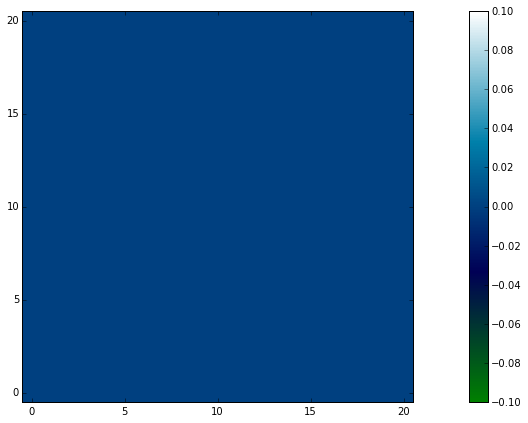

beginning policy evaluation ... 

beginning policy improvement...

ended policy improvement...



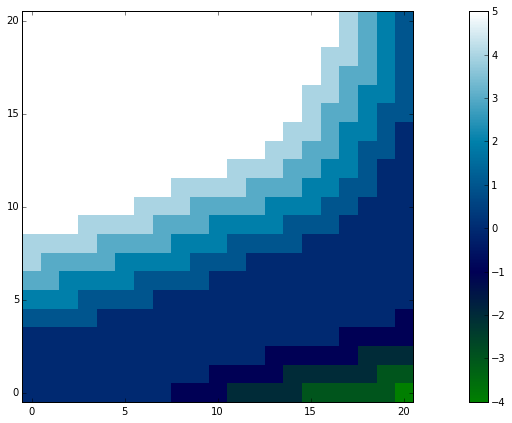

beginning policy evaluation ... 

beginning policy improvement...

ended policy improvement...



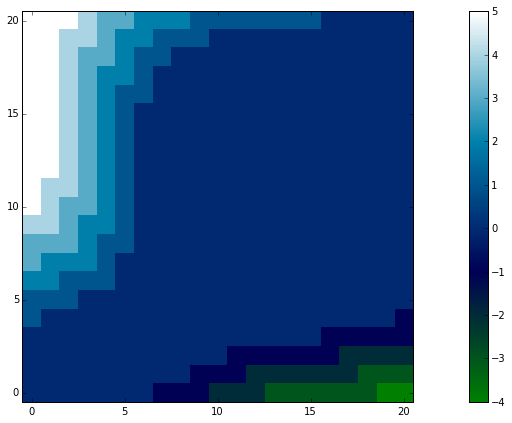

beginning policy evaluation ... 

beginning policy improvement...

ended policy improvement...



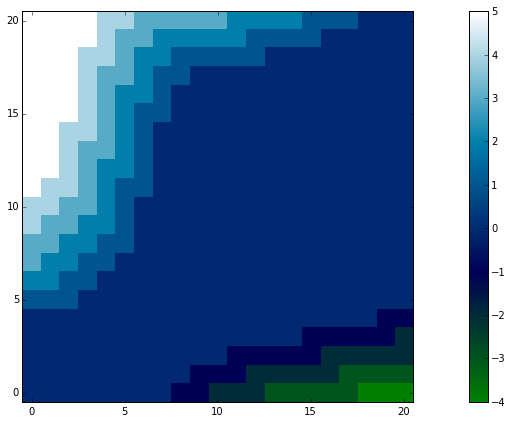

beginning policy evaluation ... 

beginning policy improvement...

ended policy improvement...



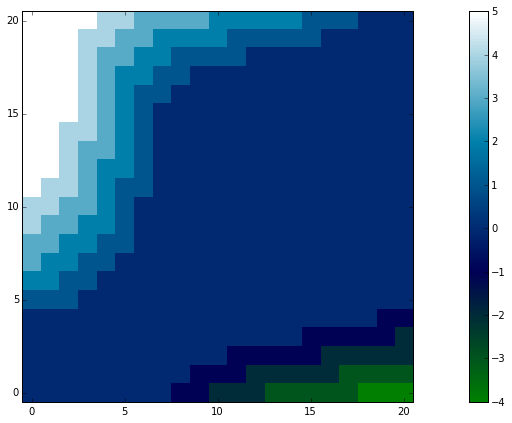

beginning policy evaluation ... 

beginning policy improvement...

ended policy improvement...



In [69]:
policyStable = 0
iterNum = 0
while( not policyStable ):
    # plot the current policy:

    figsize(20,7)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(pol_pi, interpolation='nearest', cmap=plt.cm.ocean, origin='left')
    plt.colorbar()
    plt.show()  
    # evaluate the state-value function under this policy: 
    V = jcr_policy_evaluation(V,pol_pi,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer) 
    # compute an improved policy using the most recent as a base: 
    pol_pi, policyStable = jcr_policy_improvement(pol_pi,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer)


In [84]:
V.shape

(21, 21)

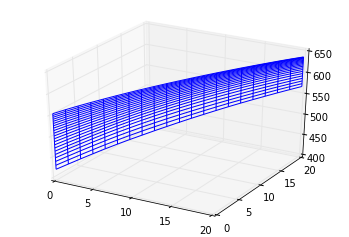

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(range(0,21), range(0,21), V)

In [81]:
ax.plot_wireframe?

In [219]:
t[5]

IndexError: index 5 is out of bounds for axis 0 with size 3